In [87]:
from get_era5_data_for_station import CreateMatchingEra5FileForStationData
from time_and_date_context_overlay import TimeAndDateContextOverlay
from create_training_sets import TrainingsFilePair


Process .dat files to create .nc files for the station

In [88]:
station_name = "Barbados"
test_year = 2020

import os
# if in station_data_as_nc folder there is no file with the name of the station, create one
station_as_nc_path = f"{os.getcwd()}/station_data_as_nc/{station_name.lower()}.nc"
needs_to_convert_to_netcdf = not os.path.isfile(station_as_nc_path)
print(f"needs_to_convert_to_netcdf: {needs_to_convert_to_netcdf}")

needs_to_convert_to_netcdf: False


In [89]:
if needs_to_convert_to_netcdf:
    
    from dat_to_nc import DatToNcConverter
    converter = DatToNcConverter(station_name.lower())
    converter.execute()
    import xarray as xr
    ds = xr.open_dataset(converter.target_directory + "/" + converter.name.lower() + ".nc")


/home/k/k203179/reconstructing-ai-for-weather-station-data/station_reconstruct/station_data_as_nc/barbados.nc has  30293  values


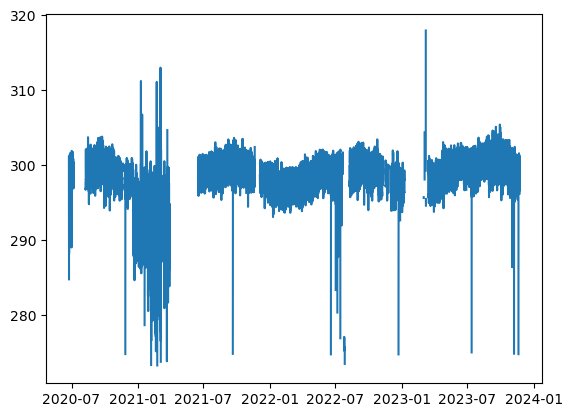

In [90]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(station_as_nc_path)

time_axis = ds.time.values
print(station_as_nc_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

# plot
plt.plot(time_axis, temperature_axis)
plt.show()

In [91]:
era5_getter = CreateMatchingEra5FileForStationData(station_name)
station_path = era5_getter.target_station_path
era5_path = era5_getter.target_era5_path
print(f"{station_name} coordinates: {era5_getter.station.get_lon_lat()}")
print(f"The data at {station_name} is inbetween {era5_getter.station.dataset.start_date} and {era5_getter.station.dataset.time_at_index(len(era5_getter.station.dataset.time)-1)}")
print("station cleared & processed file will be saved at: " + station_path)
print("era5 cleared & processed file will be saved at: " + era5_path)

Barbados coordinates: (-59.54316, 13.16443)
The data at Barbados is inbetween 2020-06-08 15:00:00 and 2023-11-22 19:00:00
station cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/barbados.nc
era5 cleared & processed file will be saved at: /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc


In [92]:
problemantic_files = era5_getter.extract_areas_from_era5_datasets()

choosing example era5 file from /work/bm1159/XCES/data4xces/reanalysis/reanalysis/ECMWF/IFS/ERA5/1hr/atmos/tas/r1i1p1
example_era5_file tas_1hr_reanalysis_era5_r1i1p1_20240101-20240131.nc
getting slices around: (-59.54316, 13.16443)
era5 min / max lin: 1065 1073
era5 min / max lat: 363 371


Processing Files: 100%|██████████| 42/42 [00:23<00:00,  1.78file/s]


Test lon / lat value differences

In [93]:
import netCDF4 as nc
import numpy as np
cropped_folder = era5_getter.target_temp_era5_folder
print(f"cropped_folder: {cropped_folder}")
last_lon = []
last_lat = []
for file in os.listdir(cropped_folder):
    ds = nc.Dataset(f"{cropped_folder}/{file.split('/')[-1]}")
    if len(last_lon):
        assert np.array_equal(last_lon, ds.variables['lon'][:]), f"{last_lon} != {ds.variables['lon'][:]} at {file}"
        assert np.array_equal(last_lat, ds.variables['lat'][:]), f"{last_lat} != {ds.variables['lat'][:]} at {file}"
    last_lon = ds.variables['lon'][:]
    last_lat = ds.variables['lat'][:]


cropped_folder: /work/bm1159/XCES/xces-work/k203179/data_sets_era5-crop_barbados


In [94]:
era5_getter.merge_era5_files()

'/work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_barbados.nc'

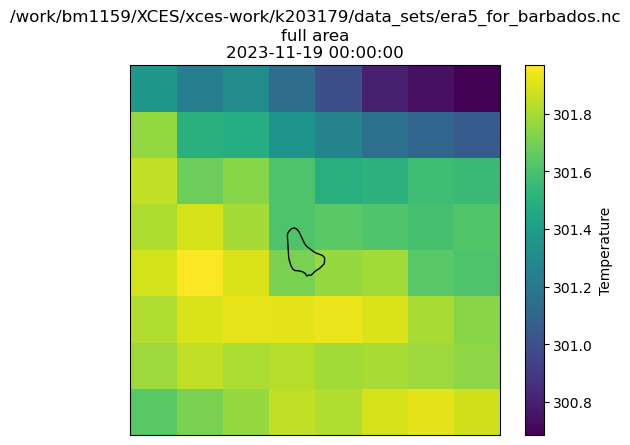

In [95]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(era5_getter.target_temp_era5_path)

plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(1)
plotter.plot()

In [96]:
processed_station_exported_at_path, \
processed_era5_for_station_exported_at_path \
    = era5_getter.transform_era5_to_match_station_time_dimension()

station data goes from 2020-06-08 15:00:00 to 2023-11-22 19:00:00
era5 data goes from 2020-06-01 00:00:00 to 2023-11-30 23:00:00
cropping time axis to intersection of station and era5 dataset
start/enddate (utc): 2020-06-08 15:00:00 / 2023-11-22 19:00:00


Checking tas:  22%|██▏       | 6535/30292 [00:03<00:12, 1934.72it/s]


KeyboardInterrupt: 

/work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc has  43636  values


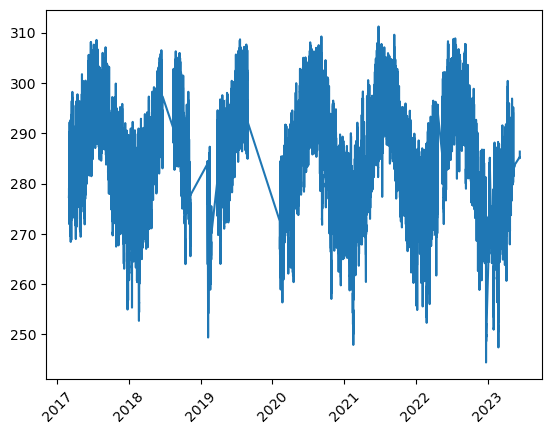

In [ ]:
# plot temperature of the station with gaps where no data is available over the years

import matplotlib.pyplot as plt
import xarray as xr

ds = xr.open_dataset(processed_station_exported_at_path)

time_axis = ds.time.values
print(processed_station_exported_at_path, "has ", len(time_axis), " values")
temperature_axis = list(ds.tas.values.flatten())

# plot
plt.plot(time_axis, temperature_axis)

# rotate x axis labels
plt.xticks(rotation=45)

plt.show()

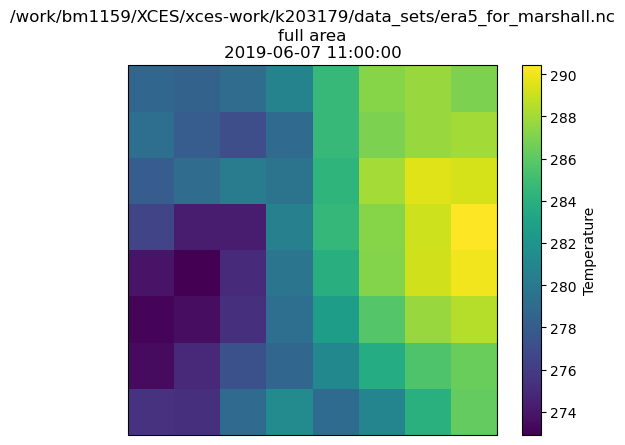

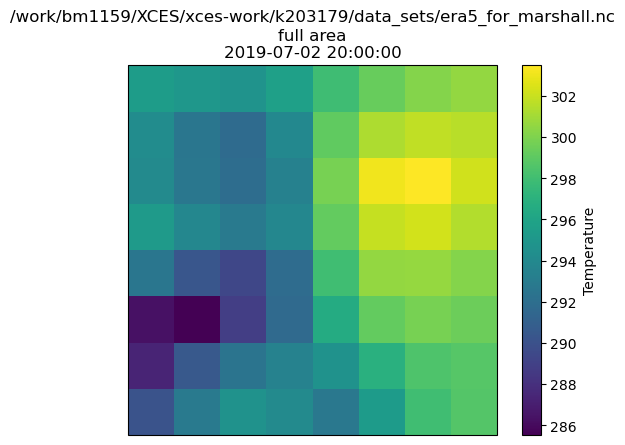

In [ ]:
from utils import DataSet, DatasetPlotter
era5_with_time_context = DataSet(processed_era5_for_station_exported_at_path)

plotter = DatasetPlotter(era5_with_time_context)
plotter.generate_time_index_list(2)
plotter.plot()

In [ ]:
time_overlay = False
if time_overlay:
    if plotter:
        plotter.dataset.dataset.close()

    time_overlayer = TimeAndDateContextOverlay()
    time_overlayer.apply_on_dataset(processed_era5_for_station_exported_at_path)

In [ ]:
if time_overlay:
    from utils import DataSet, DatasetPlotter
    era5_with_time_context = DataSet(era5_path)

    plotter = DatasetPlotter(era5_with_time_context)
    plotter.generate_time_index_list(3)
    plotter.plot()

In [ ]:
print(station_path, era5_path)
trainings_file_pair_creator = TrainingsFilePair(station_path, era5_path, test_year=test_year)
trainings_file_pair_creator.prepare_trainings_files()

/work/bm1159/XCES/xces-work/k203179/data_sets/marshall.nc /work/bm1159/XCES/xces-work/k203179/data_sets/era5_for_marshall.nc


preparing /work/bm1159/XCES/xces-work/k203179/data/val/marshall.nc: 100%|██████████| 16/16 [00:00<00:00, 1765.19it/s]
preparing /work/bm1159/XCES/xces-work/k203179/data/train/marshall.nc: 100%|██████████| 43620/43620 [00:26<00:00, 1661.09it/s]


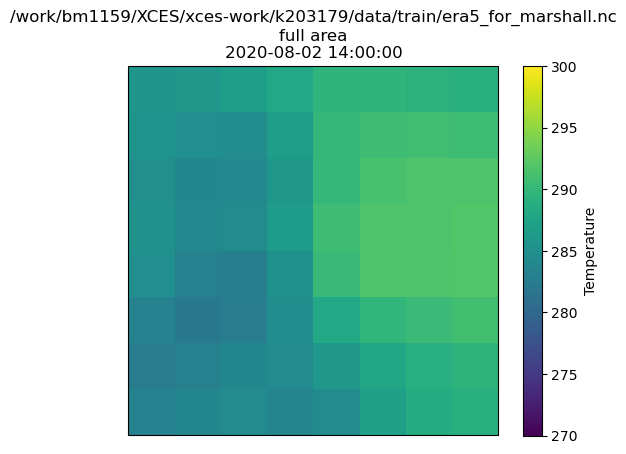

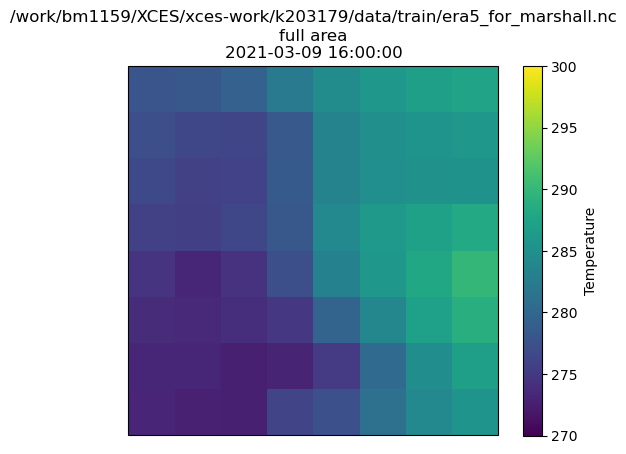

In [ ]:
from utils import DataSet, DatasetPlotter
test_expected_set = DataSet(f"/work/bm1159/XCES/xces-work/k203179/data/train/era5_for_{station_name.lower()}.nc")
plotter = DatasetPlotter(test_expected_set)
plotter.generate_time_index_list(2)
plotter.vmin = 270
plotter.vmax = 300
plotter.plot()